# Second Example of factorizing quantum linear systems with time-delayed feedback

The purpose of this notebook is to apply our method to the system explored in https://arxiv.org/abs/1606.00178

Unlike our other example, this system exhibits interesitng squeezing behavior that depends on the time delays.

To set up this system, we begin with a squeezing system having two input and two output ports in parallel with a beamsplitter (also having two input and output ports). At this point the system has a total of four ports, or eight input-output channels in the doubled-up picture where the creation and annihilation fields are considered separately.

The system is initially set up with inputs $(b_{in}(t), c_{in}(t), \xi(t), c_{out}(t-\tau) e ^{i \phi})$ and outputs $(b_{out}(t), c_{out}(t), loss, b_{in}(t))$, where the notation is the same as the cited paper. We then use the permutation matrices $P_{in}$ and $P_{out}$ to exchange the ports so they are conveniently ordered. The new input ports are $(c_{in}(t), \xi(t), b_{in}(t), c_{out}(t-\tau)e^{i \phi}))$, and the new output ports are $(b_{out}(t), loss, b_{in}(t), c_{out}(t))$. The channels are also permutted to go from the doubled-up convention where annihilation ports come first and then all creation ports, to the convention where the annihilation and creation ports alternate. This makes it easier to add the time delayed feedback since we can consider four blocks of the transfer function.

##TODO: Add the extra phase delay $\phi,$ it is currently zero.

In [10]:
import numpy
from numpy import linalg as la
import json

import sympy
from sympy import init_printing
init_printing()

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
## We use some functions from https://github.com/tabakg/potapov_interpolation

import sys
import os
P_dir = '/Users/gil/Google Drive/repos/potapov/potapov_interpolation/Potapov_Code/'
sys.path.append(P_dir)
import Roots
reload(Roots)
from Potapov import get_Potapov_vecs
from functions import der
from functions import limit

In [12]:
## Finding the poles can take a long time, so this notebook will save
## a JSON file to a chosen directory.

outdir="/Users/gil/Google Drive/repos/active_lin_systems"
sys.path.append(outdir)
output_name="generated_poles.json"
output_loc=os.path.join(outdir, output_name)

In [15]:
import utils
reload(utils)

from utils import(
    double_up,
    J,
    flat,
    make_ABCD,
    make_T,
    scale_vector_doubled_up,
    real_scaling,
    make_Sigma,
    check_J_unitary,
    check_doubled_up_func,
    check_doubled_up_mat,
    purge,
    complex_prod_deg,
    factorize_complex_poles,
    factorize_real_poles,
    factorize_deg_real_pole,
    make_Jv,
    make_Sigma,
    get_squeezed_spectrum
)

## Symbols we will use for the construction.

In [16]:
r, kappa_b, kappa_c, epsilon, Delta_a, Delta_b, phi, z = sympy.symbols('r kappa_b kappa_c epsilon Delta_a Delta_b phi z')

In [17]:
Omega_p = sympy.Matrix([[0, 1j*epsilon/2.], [1j*epsilon/2., 0.]])
Omega_m = sympy.Matrix([[Delta_a, 0], [0, Delta_b]])
Omega = double_up(Omega_p,Omega_m, second_row_minus=True)

Phi_p = sympy.zeros(4,2)
Phi_m = sympy.zeros(4,2)
Phi_m[0,0] = sympy.sqrt(2*kappa_b)
Phi_m[1,0] = sympy.sqrt(2*kappa_c)
Phi_m[0,1] = sympy.sqrt(2*kappa_b)
Phi_m[1,1] = sympy.sqrt(2*kappa_c)
Phi = double_up(Phi_p,Phi_m)

S = sympy.Matrix([[1., 0., 0., 0.],
                  [0., 1., 0., 0.],
                  [0., 0., -sympy.sqrt(1-r**2),r],
                  [0., 0.,r,sympy.sqrt(1-r**2)]])

The $A,B,C,D$ matrices are constructed using:

\begin{align*}
\tilde \Phi &= \begin{pmatrix}
\Phi_- && \Phi_+ \\
\Phi_{+}^* && \Phi_{-}^*
\end{pmatrix} \\ 
\tilde \Omega &= \begin{pmatrix}
\Omega_- && \Omega_+ \\
-\Omega_{+}^* && -\Omega_{-}^*
\end{pmatrix}
\end{align*}
 
\begin{align*}
\tilde A = - \frac{1}{2} \tilde\Phi^\flat \tilde \Phi - i \tilde \Omega, &&
\tilde B = -\tilde \Phi^\flat \tilde D, \\
\tilde C = \tilde \Phi, && \tilde D = \begin{pmatrix}
S & 0 \\ 0 & S^*
\end{pmatrix}.
\end{align*}

In [18]:
A,B,C,D = make_ABCD(S,Phi,Omega)

In [19]:
params = {kappa_b:1.0,kappa_c:0.9, r:0.0, epsilon:0.2, Delta_a: 1e-3, Delta_b: -1e-3}

In [20]:
def subs_coeffs(M_sym, params = {kappa_b:1.0,kappa_c:0.9, r:0.0, epsilon:0.2, Delta_a: 1e-3, Delta_b: -1e-3}):
    return np.matrix(np.array(M_sym.subs(params).expand()).astype(np.complex128))

In [21]:
def gen_T(params):
    A_num = subs_coeffs(A, params=params)
    B_num = subs_coeffs(B, params=params)
    C_num = subs_coeffs(C, params=params)
    D_num = subs_coeffs(D, params=params)
    
    return lambda z: D_num + C_num*la.inv(z*np.eye(A_num.shape[0]) - A_num)*B_num

In [22]:
T = gen_T(params)

## Testing numerical values

$T(z)$ Should satisfy the J-unitary property when $z$ is purely imaginary

In [174]:
M = 1#A.shape[0]/2
N = D.shape[0]/2
JA = numpy.matrix(numpy.diag([1 for i in range(M)]+[-1 for i in range(M)]))
JD = numpy.matrix(numpy.diag([1 for i in range(N)]+[-1 for i in range(N)]))

In [175]:
all([check_J_unitary(T, i*1j) for i in range(-10,10)])

True

## Root finding

In [176]:
T_det = lambda z: 1./la.det(T(z))
# T_det_der = lambda z: der(T_det,z)
# poles = Roots.get_roots_rect(T_det, T_det_der, 0.,0.,5.,5.,N=10)

In [177]:
poles = []

for i in numpy.linspace(-2,2,10):
    for j in numpy.linspace(-2,2,10):
        x1,x2,x3 = i+j*1j-0.101, i+j*1j+0.101, i+j*1j+0.001
        p = Roots.Muller(x1,x2,x3,T_det)
        poles.append(p)

In [178]:
significant_poles = purge(poles, eps = 1e-2, max_norm=1e5)
significant_poles

[(-3.7015243577634105-0.00018916037312600997j),
 (-3.9000197761532998-0.00013220582432248683j)]

In [179]:
significant_poles = [p.real for p in significant_poles]

## Factorize function

In [180]:
J4 = numpy.matrix(numpy.diag([1]*4+[-1]*4))

In [181]:
vecs = get_Potapov_vecs(T,[s for s in significant_poles])
u1, u2 = vecs

w1 = scale_vector_doubled_up(u1)
w2 = scale_vector_doubled_up(u2)
v1, v2 = real_scaling(w1, w2)
if (v1.H*J4*v2).imag < 0:
    v1, v2 = v2, v1
    significant_poles.reverse()
U = numpy.matrix([[1,1],[-1j,1j]])
V = numpy.hstack([v1,v2])*U
V_flat = JA*V.H*JD

In [182]:
## Check V is doubled-up
check_doubled_up_mat(V)

True

## We should have $I = V^\flat*V$ and $P_v = V*V^\flat$ should be a projector.

In [183]:
Pv = V*V_flat

In [184]:
## Check V_flat * V is close the I.
print la.norm(V_flat*V - numpy.matrix(numpy.eye(2)))

1.25800262561e-14


In [185]:
## Check Pv is a projector.
print la.norm(Pv - Pv**2)

1.25810060213e-14


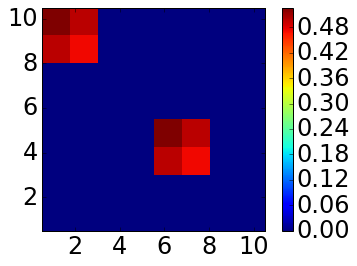

In [186]:
## Check what the projection looks like
plt.imshow((V*V_flat).real, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
plt.colorbar()

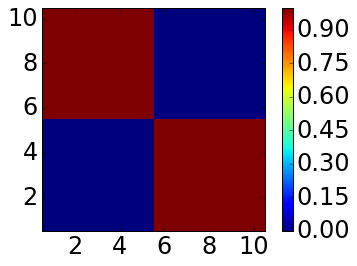

In [187]:
plt.imshow((V_flat*V).real, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
plt.colorbar()

In [188]:
## Construct factors for real roots.

F1 = lambda z: (numpy.matrix([[(z + significant_poles[1])/(z-significant_poles[0]), 0],
                            [0, (z + significant_poles[0])/(z-significant_poles[1])]])
               )

T_factorized_1 = lambda z: numpy.matrix(numpy.eye(D.shape[0])) - V*V_flat + V*la.inv(U)*F1(z)*(U)*V_flat

B_constant = T(1e5)*la.inv(T_factorized_1(1e5))

fact1 = lambda z: (B_constant*T_factorized_1(z))

### Ensure the generated factor is J-unitary and doubled-up

In [189]:
# T_factorized_1(10j)*J4*T_factorized_1(10j)-J4

In [190]:
print all([[check_J_unitary(T,i+1j*j+1e-2)
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T,i+1j*j+1e-2)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


In [191]:
print all([[check_J_unitary(T_factorized_1,i+1j*j+1e-2)
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_factorized_1,i+1j*j+1e-2)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


### Check the factor equals the original transfer function

In [192]:
def plot_T_and_fact(T, fact1, z):
    plt.title("Original transfer function, real part.")
    plt.imshow((T(z)).real, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
    plt.colorbar()
    plt.show()

    plt.title("New factor, real part.")
    plt.imshow((fact1(z)).real, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
    plt.colorbar()
    plt.show()

    plt.title("Original transfer function, imaginary part.")
    plt.imshow((T(z)).imag, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
    plt.colorbar()
    plt.show()

    plt.title("New factor, imaginary part.")
    plt.imshow((fact1(z)).imag, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
    plt.colorbar()
    plt.show()

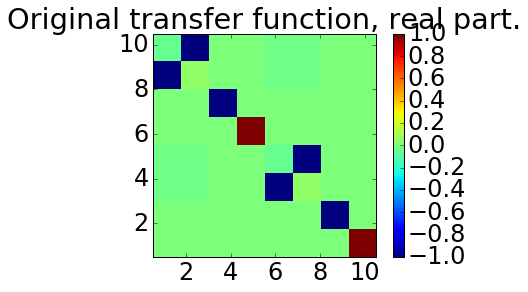

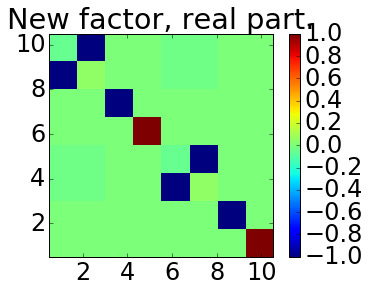

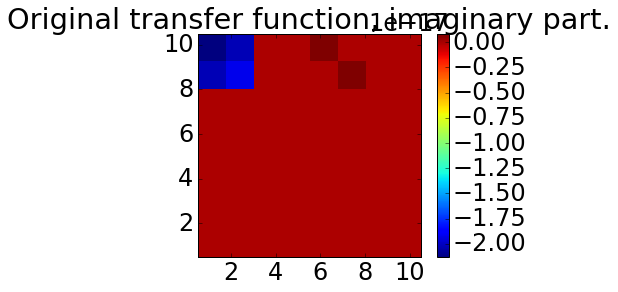

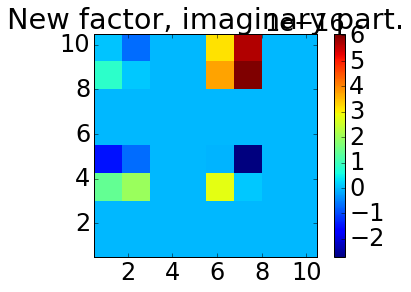

In [193]:
plot_T_and_fact(T, fact1, 0)

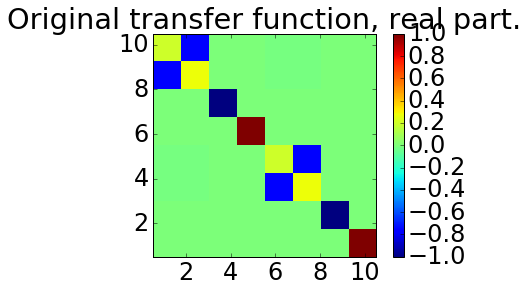

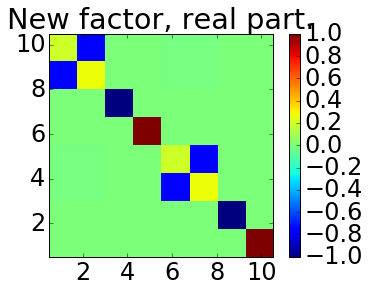

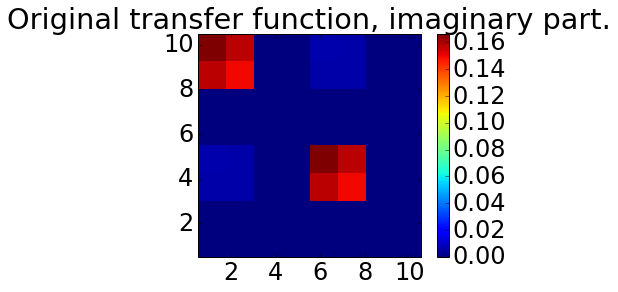

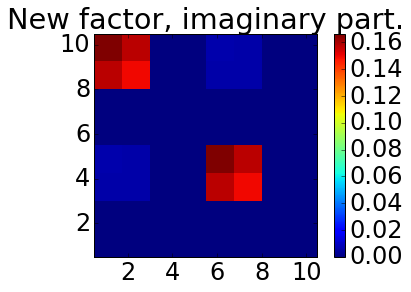

In [194]:
plot_T_and_fact(T, fact1, 1j+1.)

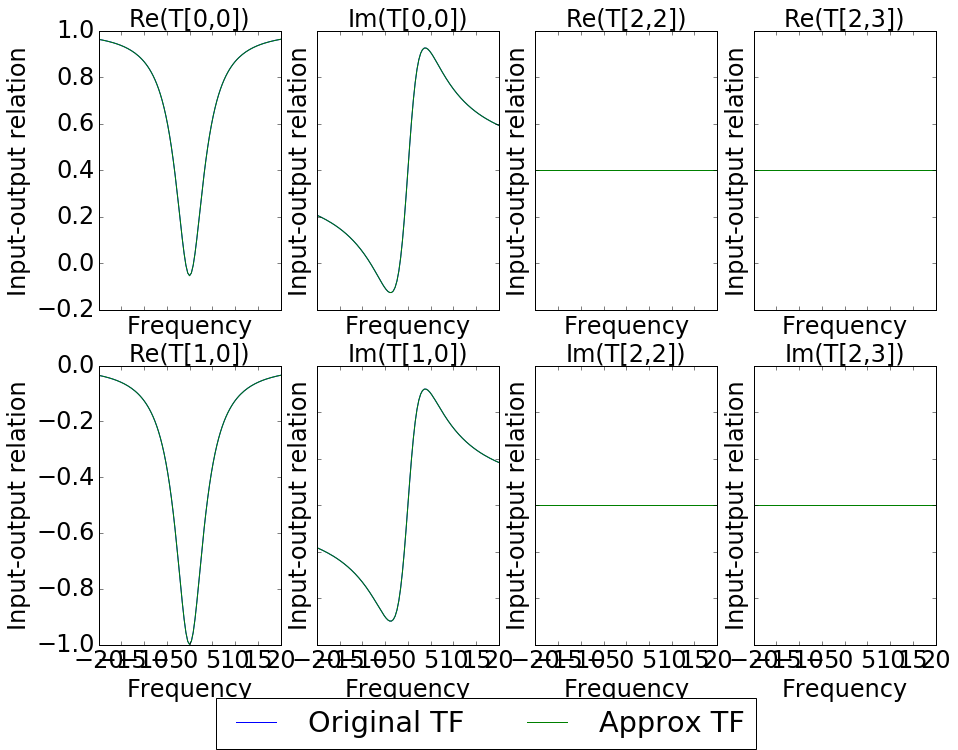

In [195]:
xr = numpy.linspace(-100,100,501)
xr_im = xr*1j
yr = numpy.array(map(T, xr_im))
zr = numpy.array(map(fact1, xr_im))

f, axarr = plt.subplots(2, 4, figsize=(15,11))

l1, = axarr[0, 0].plot(xr, yr[:,0,0].real)
l2, = axarr[0, 0].plot(xr, zr[:,0,0].real)
axarr[0, 0].set_title('Re(T[0,0])',fontsize= 24)

axarr[0, 1].plot(xr, yr[:,0,0].imag)
axarr[0, 1].plot(xr, zr[:,0,0].imag)
axarr[0, 1].set_title('Im(T[0,0])' ,fontsize= 24)

axarr[1, 0].plot(xr, yr[:,1,0].real)
axarr[1, 0].plot(xr, zr[:,1,0].real)
axarr[1, 0].set_title('Re(T[1,0])',fontsize= 24 )

axarr[1, 1].plot(xr, yr[:,1,0].imag)
axarr[1, 1].plot(xr, zr[:,1,0].imag)
axarr[1, 1].set_title('Im(T[1,0])',fontsize= 24 )

###

axarr[0,2].plot(xr, yr[:,2,2].real)
axarr[0,2].plot(xr, zr[:,2,2].real)
axarr[0,2].set_title('Re(T[2,2])',fontsize= 24 )

axarr[1,2].plot(xr, yr[:,2,2].imag)
axarr[1,2].plot(xr, zr[:,2,2].imag)
axarr[1,2].set_title('Im(T[2,2])',fontsize= 24 )

axarr[0,3].plot(xr, yr[:,2,3].real)
axarr[0,3].plot(xr, zr[:,2,3].real)
axarr[0,3].set_title('Re(T[2,3])',fontsize= 24 )

axarr[1,3].plot(xr, yr[:,2,3].imag)
axarr[1,3].plot(xr, zr[:,2,3].imag)
axarr[1,3].set_title('Im(T[2,3])',fontsize= 24 )




f.legend([l1, l2],["Original TF", "Approx TF"],
           bbox_to_anchor=(0.2, 0.001, 0.5, .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)


for ax in axarr.flat:
    ax.set(xlabel='Frequency', ylabel='Input-output relation', xlim=(-20,20))
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axarr.flat:
    ax.label_outer()
    

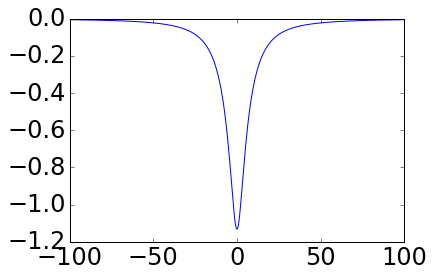

In [197]:
## Analysis of squeezing spectrum.

PP = get_squeezed_spectrum(zr)
plt.plot(xr, -PP)

## Example 2. Next we close the feedback loop with a time delay and

### Feedback operation

In [47]:
def perm(N, tuples):
    P_tot = np.matrix(numpy.eye(N))
    for t in tuples:
        P = np.matrix(numpy.zeros((N,N)))
        for i in range(N):
            if i == t[0]:
                P[t[1],t[0]] = 1
            elif i == t[1]:
                P[t[0],t[1]] = 1
            else:
                P[i,i] = 1
        P_tot = P * P_tot ## New operators come from the left...
    return P_tot

In [48]:
## P_in and P_out are permutations for arranging the channels 
## in a convenient way. They are used in the 'doubled-up' convention
## This means that if we permute the annihilation ports i and j
## we must also permute the creation ports i+N and j+N.

P_in = perm(8, [(1,2), (0,1), (5,6), (4,5)])
P_out = perm(8, [(1,2),(2,3), (5,6),  (6,7)])

In [49]:
## P_conv switches the convention being used. 
## In the original convention, the annihilation ports are the 
## first N (0,1,2,3) while the creation ports are the
## last N (4,5,6,7) are for the creation ports.
## In the new 'consecutive' convention, the even
## ports correspond to the annihilation and the odd ports
## to the creation ports.

P_conv = numpy.matrix(np.zeros((8,8)))
p_conv_list = [0,4,1,5,2,6,3,7]
for i in range(8):
    P_conv[i, p_conv_list[i]] = 1

In [50]:
T_o = lambda z: P_conv*P_out*T(z)*P_in*P_conv.T
T1 = lambda z: T_o(z) [0:4,0:4]
T2 = lambda z: T_o(z)[0:4,4:8]
T3 = lambda z: T_o(z) [4:8,0:4]
T4 = lambda z: T_o(z) [4:8, 4:8]

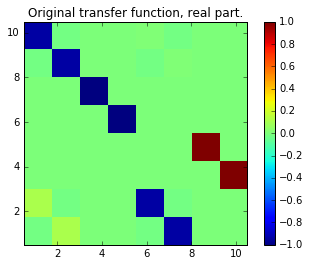

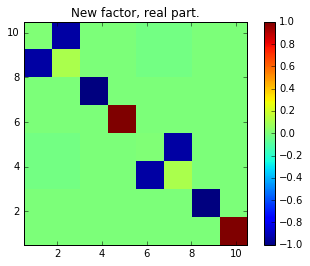

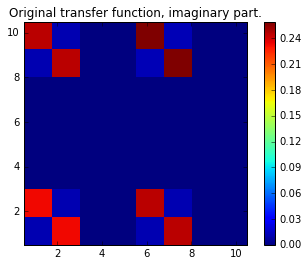

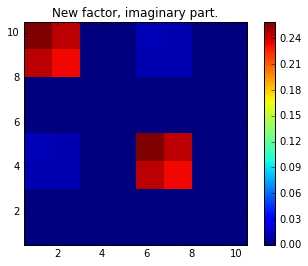

In [51]:
plot_T_and_fact(T_o, fact1, 1j)

### Check some properties that should be true

In [52]:
Jv = numpy.matrix([[1,0,0,0],[0,-1,0,0],[0,0,1,0],[0,0,0,-1]])

In [53]:
## Should be zero
print la.norm(T1(0)*Jv*T1(0).H +T2(0)*Jv*T2(0).H - Jv) 

2.48642173445e-16


In [54]:
## Should be zero
print la.norm(T1(0)*Jv*T3(0).H +T2(0)*Jv*T4(0).H) 

3.24170876288e-15


In [55]:
## Should be zero
print la.norm(T3(0)*Jv*T3(0).H +T4(0)*Jv*T4(0).H - Jv)

3.41323105046e-15


### Feedback without time delay

In [56]:
I = numpy.matrix(numpy.eye(4))

In [57]:
T_tilde_0 = lambda z: T1(z) + T2(z)*la.inv(I - T4(z)) * T3(z)

In [58]:
print all([[check_J_unitary(T_tilde_0,i+1j*j + 0.01, conv="consecutive", eps=1e-7)
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_tilde_0,i+1j*j + 0.01, conv="consecutive", eps=1e-7, verbose=False)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


### Feedback with time delay

In [59]:
t = 1.

In [60]:
delta = 0. ## Phase shift

In [61]:
E = lambda z: numpy.matrix(numpy.diag(numpy.exp( [delta*1j, -delta*1j, delta*1j-t*z, -delta*1j-t*z] )))

In [62]:
print all([[check_doubled_up_func(E,i+1j*j + 0.01, conv="consecutive", eps = 1e-7)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True


In [63]:
T_tilde = lambda z: T1(z) + T2(z) * la.inv( E(-z) - T4(z) ) * T3(z)

In [64]:
print all([[check_J_unitary(T_tilde,i+1j*j + 0.01, conv="consecutive")
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_tilde,i+1j*j + 0.01j, conv="consecutive", eps = 1e-2, verbose=False)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


In [65]:
## Function for generating T_Tilde
def gen_T_tilde(params):
    T = gen_T(params)
    T_o = lambda z: P_conv*P_out*T(z)*P_in*P_conv.T
    T1 = lambda z: T_o(z) [0:4,0:4]
    T2 = lambda z: T_o(z)[0:4,4:8]
    T3 = lambda z: T_o(z) [4:8,0:4]
    T4 = lambda z: T_o(z) [4:8, 4:8]
    T_tilde = lambda z: T1(z) + T2(z) * la.inv( E(-z) - T4(z) ) * T3(z)
    return T_tilde

### Plot of input-output function

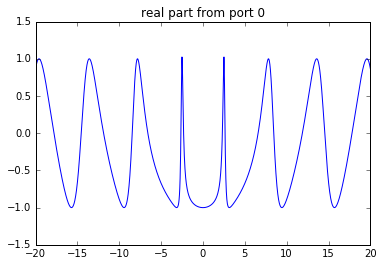

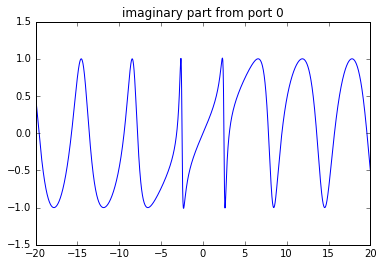

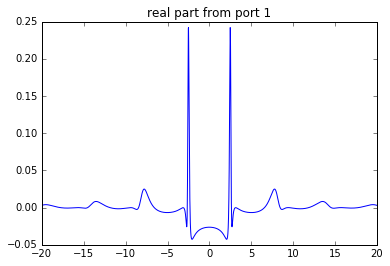

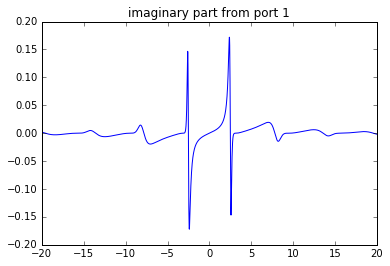

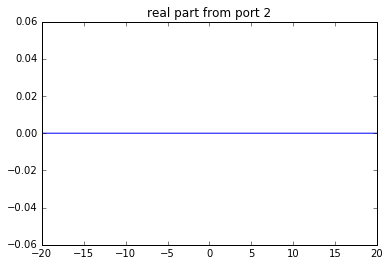

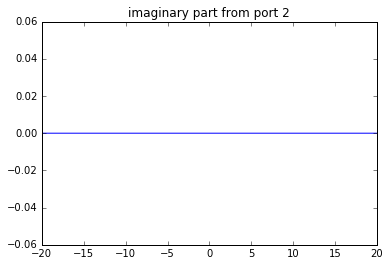

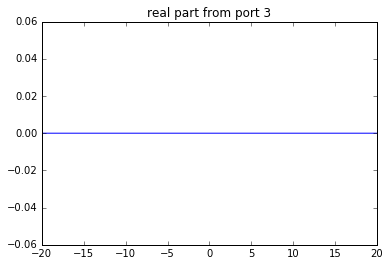

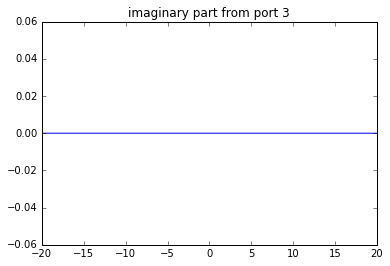

In [66]:
xr = numpy.linspace(-20,20,2000)
yr = numpy.array(map(T_tilde, xr*1j))

for i in range(yr.shape[1]):
    plt.title("real part from port %s" % str(i))
    plt.plot(xr, yr[:,i,0].real)
    plt.show()
    plt.title("imaginary part from port %s" % str(i))
    plt.plot(xr, yr[:,i,0].imag)
    plt.show()

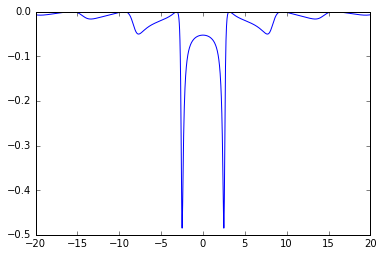

In [67]:
# Analysis of squeezing spectrum.

PP = get_squeezed_spectrum(yr)
plt.plot(xr, -PP)

## Next, find the roots for $\tilde T(z)$.

In [68]:
T_tilde_det = lambda z: 1./la.det(T_tilde(z))

### We we use grid + Muller search.

In [69]:
def root_search(T_tilde, x_space = (-3.,0.,50), y_space = (-50,50,40)):
    """Look for roots using a grid method.
    
    Applies Muller method to points across a grid.
    To check for reduncancy, we use the Cauchy method near each 
    found pole for other poles
    
    Args:
        T_tilde (function): Function whose poles we look for.
        x_space(3-tuple): min_x, max_x, and num_x
        y_space(3-tuple): min_y, max_y, and num_y
        
    Returns:
        D (dict): maps "poles" to a list of found poles without redundancy, 
            and maps "boxes" to a dict mapping each pole p
            to two dicts: "new_poles" are the poles near p,
            and "root_count" is the number of roots near p. 
    
    """
    T_tilde_det = lambda z: 1./la.det(T_tilde(z))
    f_p = lambda z: der(T_tilde_det, z)

    poles_tilde_not_purged = []

    print("brute force search")
    for i in numpy.linspace(*x_space):
        for j in numpy.linspace(*y_space):
            x1,x2,x3 = i+j*1j-0.101, i+j*1j+0.101, i+j*1j+0.001
            p = Roots.Muller(x1,x2,x3,T_tilde_det)
            poles_tilde_not_purged.append(p)
            
    print("get rid of closely overlapping poles")
    poles_tilde = numpy.asarray(purge(Roots.inside_boundary(poles_tilde_not_purged, 0., 0., 100., 100.), 1e-2))
    
    nearby_poles = []
    boxes = {}
    print("looking at boxes near brute force poles")
    for p in [p for p in poles_tilde if y_space[0] < p.imag < y_space[1]]:
        new_poles = Roots.get_roots_rect(T_tilde_det, f_p, p.real, p.imag, 0.1, 0.1, N = 1000) 
        root_count = Roots.count_roots_rect(T_tilde_det, f_p, p.real, p.imag, 0.1, 0.1, N = 1000)
        nearby_poles.append(new_poles)
        boxes[p] = {"root_count" : root_count, "new_poles": new_poles}
        
    print("purging up to high precision")
    nearby_poles = purge(np.concatenate(nearby_poles), 1e-6)
        
    D = {"poles" : nearby_poles, "boxes": boxes}
    return D

In [76]:
def test_root_search(params):
    """Testing root search over small number of points.
    """
    DD = {}
    T_tilde = gen_T_tilde(params)
    D = root_search(T_tilde, x_space = (-3.,0.,5), y_space = (-30,30,15))
    DD[str(params)] = D
    return DD

In [77]:
DD_test = test_root_search(params)

brute force search
get rid of closely overlapping poles
looking at boxes near brute force poles
(3.30383019215e-05-1.60419937154e-06j)
(3.42500591733e-05-1.92705522515e-06j)
(3.72773136895e-05-2.35911562201e-06j)
(4.87093446802e-05-3.14745056874e-06j)
(4.84168410338e-05-1.09415444863e-06j)
(3.71117119459e-05+4.2203240698e-07j)
(3.41421359137e-05+5.2978344272e-07j)
(3.29470238596e-05+3.14428620002e-07j)
(3.31371241389e-05-1.55537789589e-06j)
(3.42992798497e-05-1.98578544076e-06j)
(3.7284793289e-05-2.26141648255e-06j)
(3.71089304795e-05+3.23562552369e-07j)
(3.41056119268e-05+4.58370491584e-07j)
(3.30438483051e-05+2.61646252109e-07j)
(3.31045104611e-05-1.72367558038e-06j)
(3.43634134747e-05-1.86565939192e-06j)
(4.84824856924e-05-3.54783265279e-06j)
(4.82775608239e-05-6.50763268599e-07j)
(3.42418886957e-05+3.96797063318e-07j)
(3.30180169723e-05+4.31231176282e-07j)
(3.42936311522e-05-1.82802216633e-06j)
(3.73787460426e-05-2.39997000081e-06j)
(3.72174870104e-05+4.52207180521e-07j)
(3.4169778

In [78]:
DD_test[str(params)]['poles']

[(-1.9557341703557469-26.768606442105948j),
 (-1.9565188445708386-26.775993465191391j),
 (-1.6938890562583151-20.527412779434453j),
 (-1.6924468425695027-20.5178858496187j),
 (-1.343320713895586-14.313917943274532j),
 (-1.3401284901974975-14.300710865616733j),
 (-0.83700708495594089-8.211027624996019j),
 (-0.82744725881412085-8.1912664060056279j),
 (-0.82744725881412073+8.1912664060056279j),
 (-0.83700708495594101+8.211027624996019j),
 (-1.3401284901974975+14.300710865616733j),
 (-1.3433207138955863+14.313917943274532j),
 (-1.6924468425695027+20.5178858496187j),
 (-1.6938890562583151+20.527412779434453j),
 (-1.9557341703557469+26.768606442105948j),
 (-1.9565188445708386+26.775993465191391j)]

In [79]:
params

In [80]:
DD_test.values()[0]['boxes']

{(-1.9656026900545116+26.764626454164841j): {'new_poles': [(-1.9557341703557469+26.768606442105948j),
   (-1.9565188445708386+26.775993465191391j)],
  'root_count': (1.9997365437282331+0.00029081594453747583j)},
 (-1.9656026900545107-26.764626454164841j): {'new_poles': [(-1.9557341703557469-26.768606442105948j),
   (-1.9565188445708386-26.775993465191391j)],
  'root_count': (1.9996922863230417+0.00028471303957849914j)},
 (-1.9562861814518799-26.783558118619876j): {'new_poles': [(-1.9565188445708386-26.775993465191391j),
   (-1.9557341703557469-26.768606442105948j)],
  'root_count': (1.9997476321594529+0.00031425836318593747j)},
 (-1.9562861814518797+26.783558118619876j): {'new_poles': [(-1.9557341703557467+26.768606442105948j),
   (-1.9565188445708386+26.775993465191391j)],
  'root_count': (1.9996760223291872+0.00031553398026476498j)},
 (-1.9499831454315129-26.757882127890841j): {'new_poles': [(-1.9565188445708386-26.775993465191391j),
   (-1.9557341703557469-26.768606442105948j)],
  '

In [83]:
def full_root_search(params):
    print("initializing root search for params: %s" %str(params))
    DD = {}
    T_tilde = gen_T_tilde(params)
    print("successfully generated T_tilde. Starting root search")
    D = root_search(T_tilde, x_space = (-3.,0.,5), y_space = (-50,50,20))
    DD[str(params)] = D
    return DD

In [84]:
params_list = [{kappa_b:1.0, kappa_c:0.9, r:0.0, epsilon:0.2, Delta_a: 1e-3, Delta_b: -1e-3},
               {kappa_b:1.0, kappa_c:0.3, r:0.0, epsilon:0.2, Delta_a: 1e-3, Delta_b: -1e-3},
               {kappa_b:1.0, kappa_c:0.1, r:0.0, epsilon:0.2, Delta_a: 1e-3, Delta_b: -1e-3},
               {kappa_b:1.0, kappa_c:1.0, r:0.0, epsilon:0.2, Delta_a: 1e-3, Delta_b: -1e-3},
               {kappa_b:3.0, kappa_c:0.9, r:0.0, epsilon:0.2, Delta_a: 1e-3, Delta_b: -1e-3},
               {kappa_b:1.0, kappa_c:0.9, r:0.0, epsilon:0.4, Delta_a: 1e-3, Delta_b: -1e-3},
               {kappa_b:1.0, kappa_c:0.9, r:0.0, epsilon:0.8, Delta_a: 1e-3, Delta_b: -1e-3},
               {kappa_b:1.0, kappa_c:0.9, r:0.0, epsilon:5.0, Delta_a: 1e-3, Delta_b: -1e-3},
               {kappa_b:1.0, kappa_c:0.9, r:0.0, epsilon:0.0, Delta_a: 1e-3, Delta_b: -1e-3},
               {kappa_b:1.0, kappa_c:0.9, r:0.05, epsilon:0.2, Delta_a: 1e-3, Delta_b: -1e-3},
               {kappa_b:1.0, kappa_c:0.9, r:0.3, epsilon:0.2, Delta_a: 1e-3, Delta_b: -1e-3}]

In [85]:
def root_search_over_params():
    try:
        DD = load_roots_from_file(output_loc)
        print("loaded roots from file")
    except:
        print("could not load from file. Generating new...")
        DD = {}
    print("starting root search for all parameters")
    for params in params_list:
        if str(params) not in DD:
            DD.update(full_root_search(params))
    print("completed root search over all params. Writing to file next")
    with open(output_loc, 'w') as outfile:
        json.dump(str(DD), outfile)
    return DD

In [86]:
def load_roots_from_file(output_loc):
    with open(output_loc) as f:
        data = json.load(f)
    return eval(data)

In [87]:
DD = load_roots_from_file(output_loc)

In [ ]:
## Searching over roots... this is commented out because it takes a long time
## Instead we have load_roots_from_file above.
# DD = root_search_over_params()

In [88]:
def plot_poles(poles, x_lim = (-5,1), y_lim = (-50,50), title=""):
    plt.figure(figsize=(10,5))
    plt.scatter(poles.real,poles.imag, )
    # plt.title("Poles", fontsize=18)
    plt.xlim(*x_lim)
    plt.ylim(*y_lim)
    plt.xlabel("Real part (kappa)", fontsize=32)
    plt.ylabel("Imaginary part (omega)", fontsize=32)
    plt.title(title, fontsize=32)

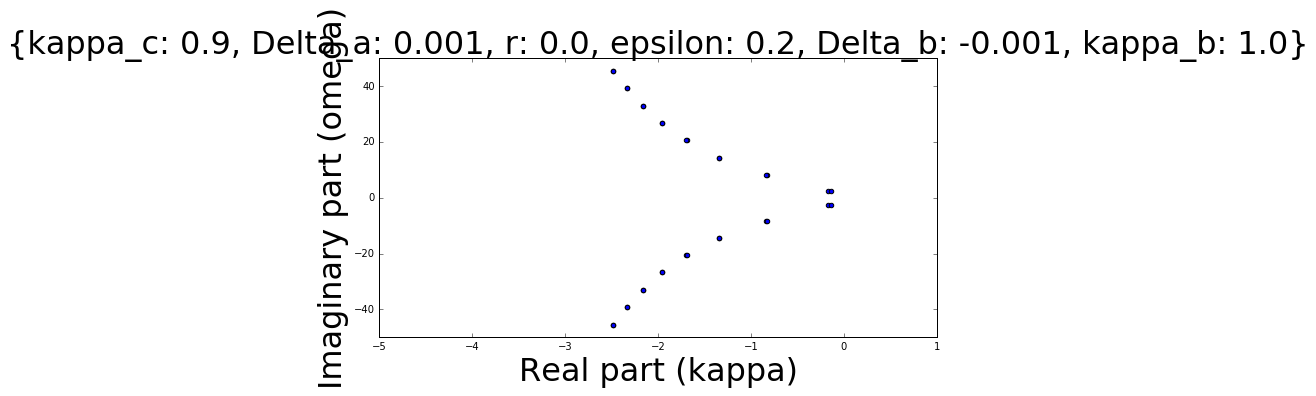

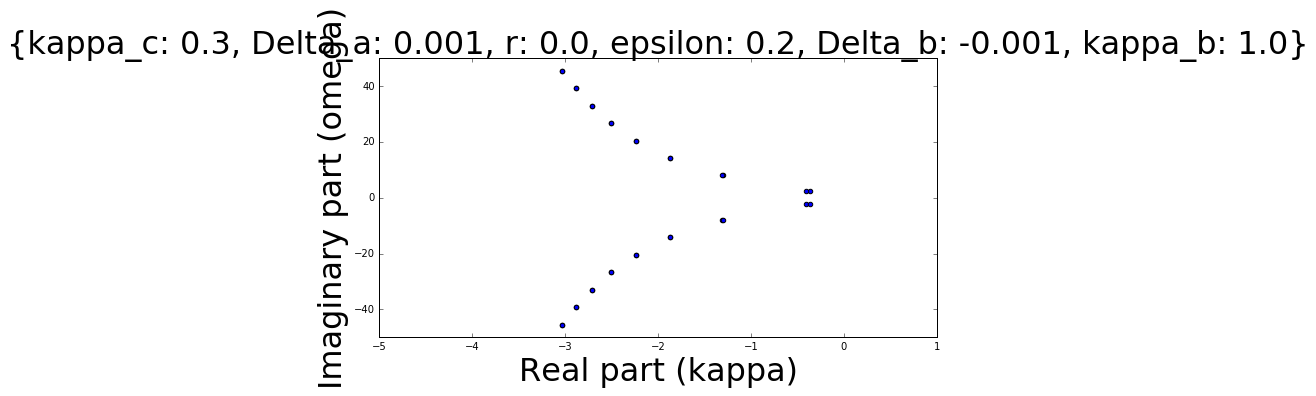

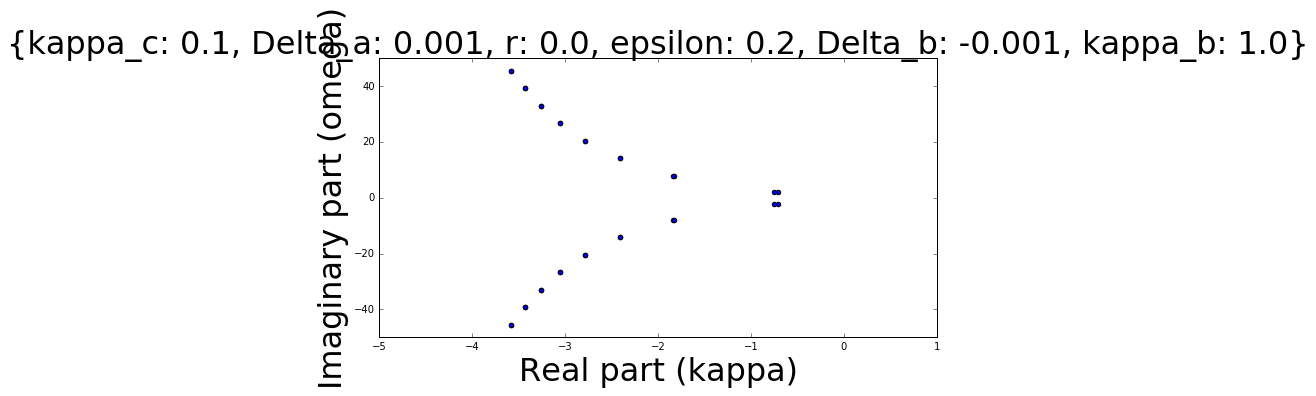

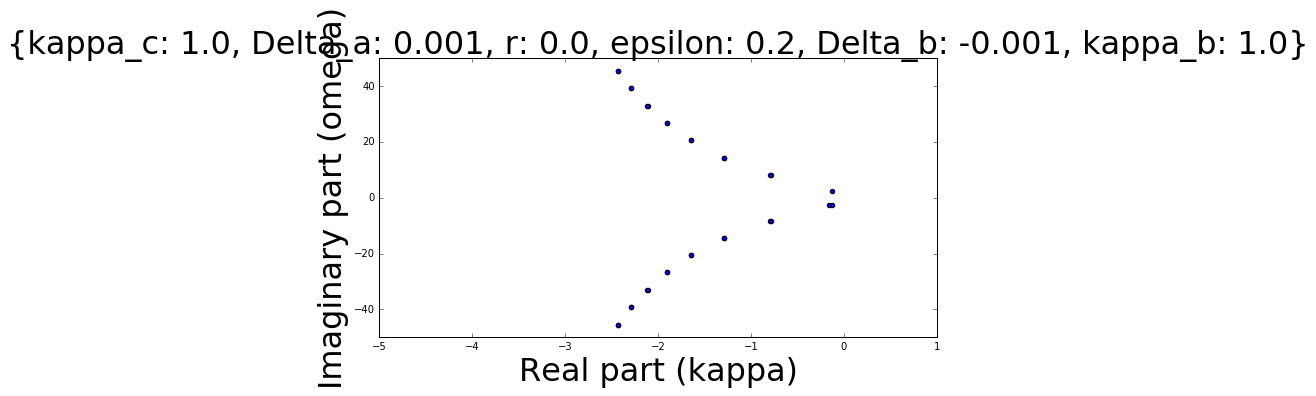

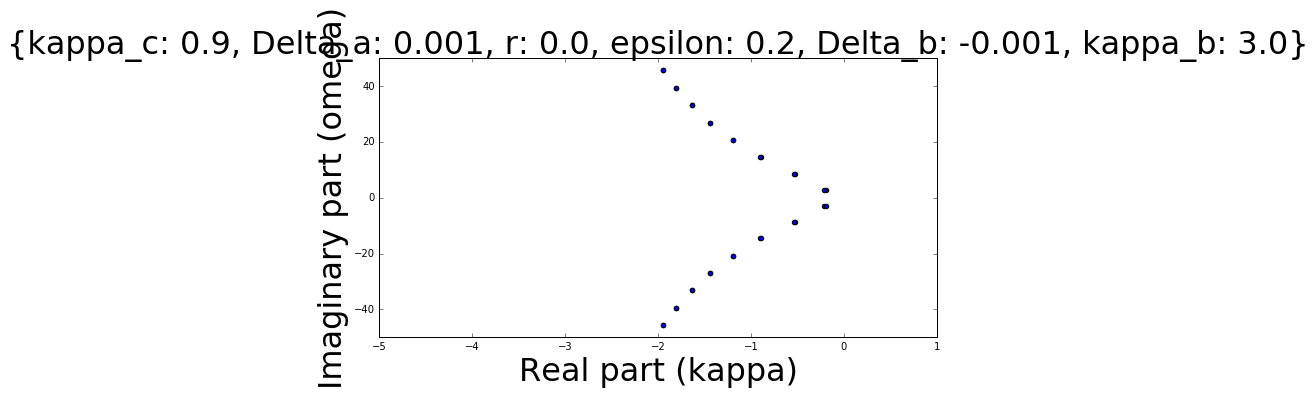

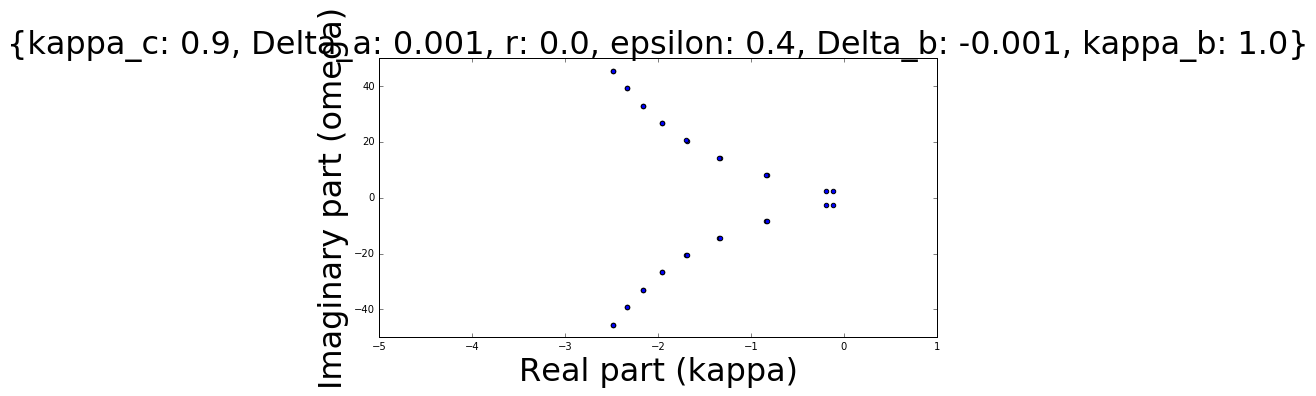

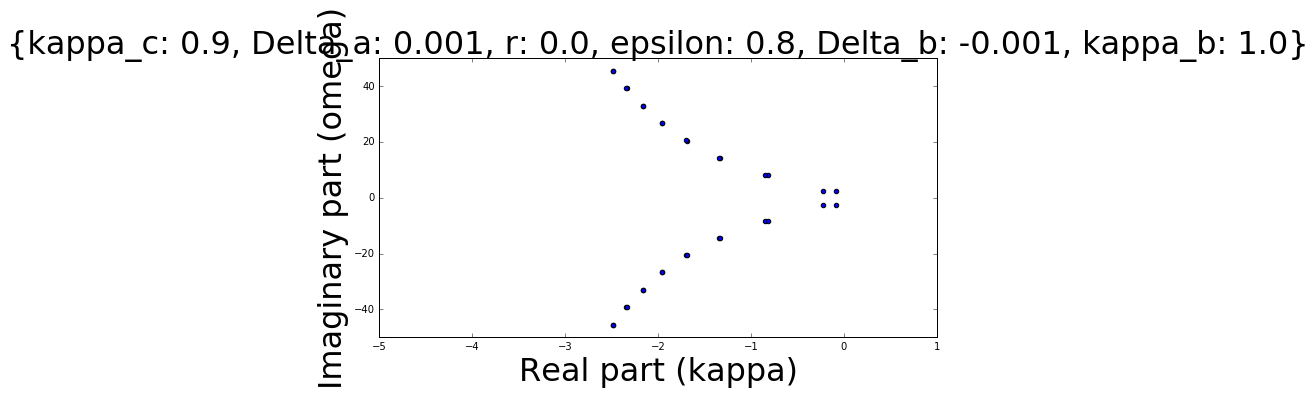

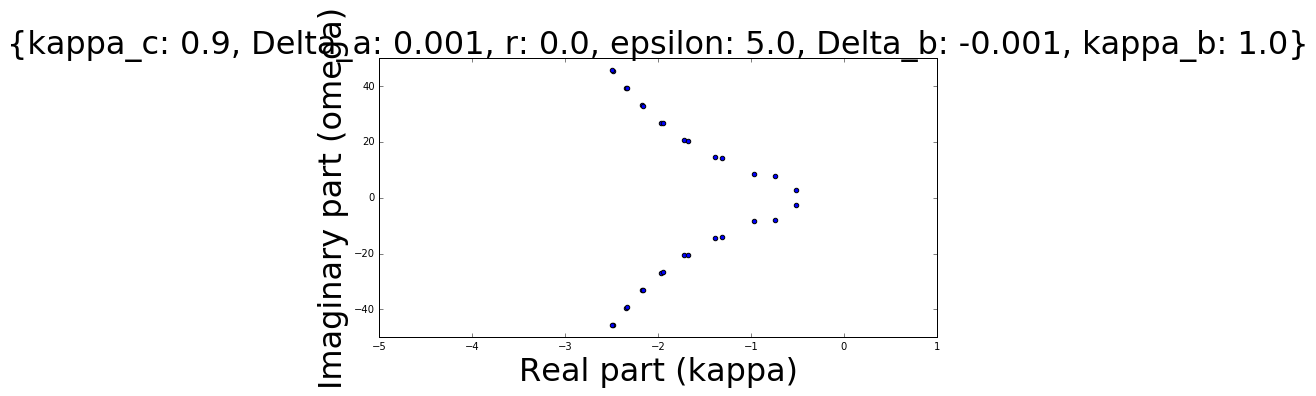

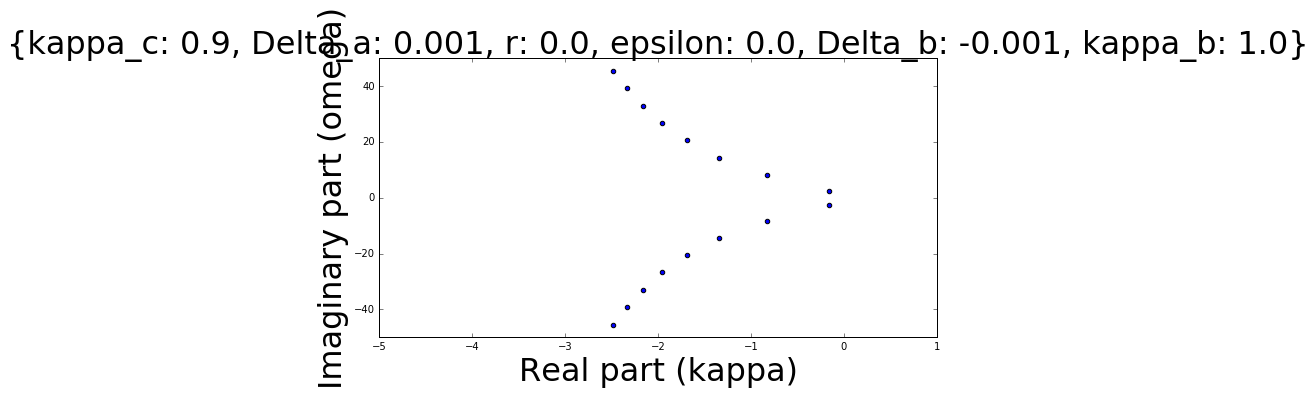

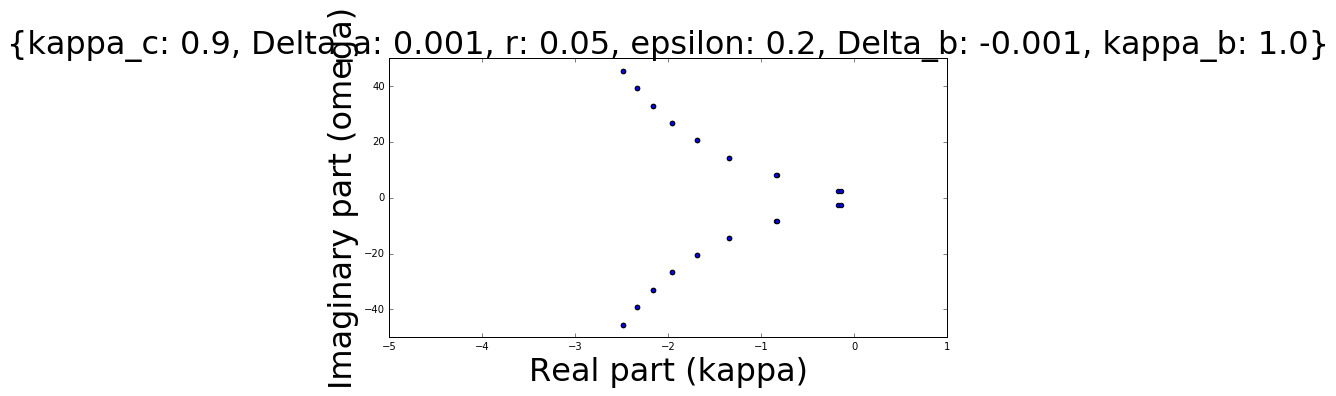

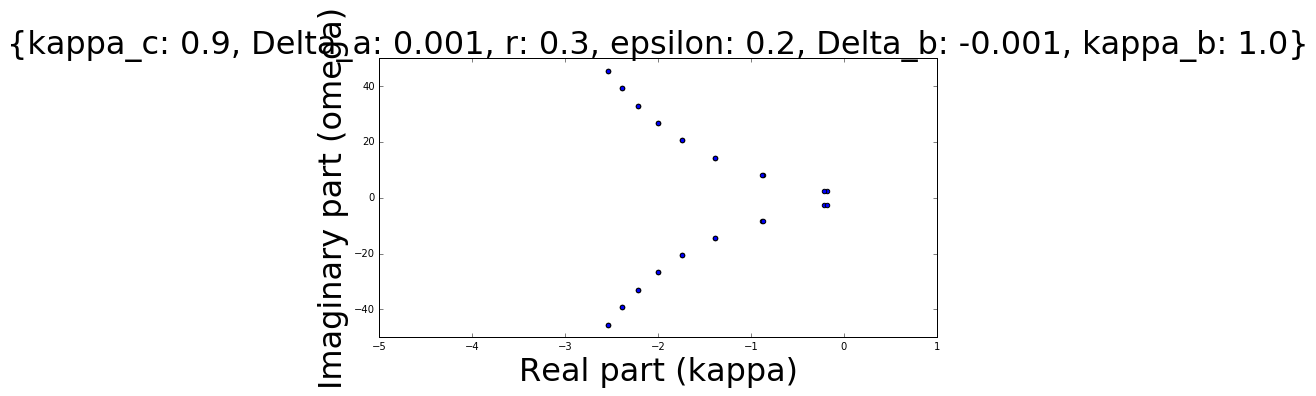

In [89]:
for params_current in params_list:
    params_key = str(params_current)
    DD_poles = np.array(DD[params_key]['poles'])
    plot_poles(DD_poles, title = params_key)

In [90]:
params = params_list[0]

In [91]:
poles_tilde = np.array(DD[str(params)]['poles'])

### Organize the poles into different categories

In [92]:
real_cutoff = 1e-3
complex_poles = [p for p in poles_tilde if abs(p.imag) >= real_cutoff]
complex_poles.sort(key=lambda z: abs(z.imag))

real_poles = [p.real for p in poles_tilde if abs(p.imag) < real_cutoff]
pos_complex_poles = [p for p in complex_poles if p.imag > real_cutoff]
neg_complex_poles =  [p for p in complex_poles if p.imag < -real_cutoff]

In [96]:
f_p = lambda z: der(T_tilde_det, z)

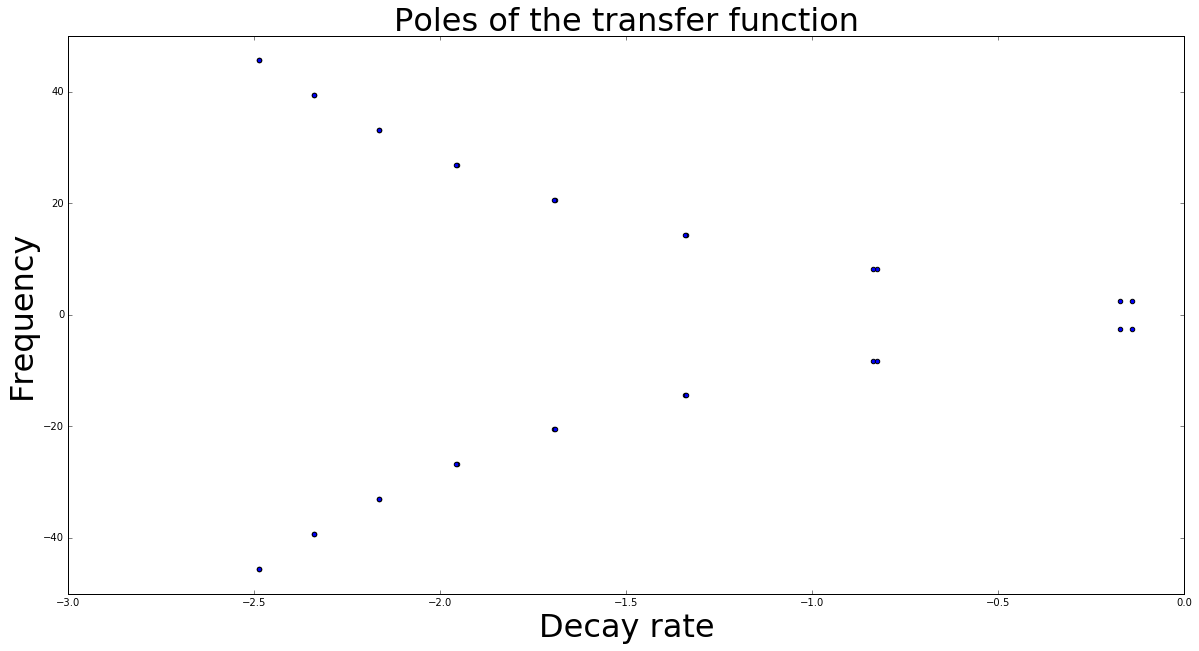

In [97]:
plt.figure(figsize=(20,10))
plt.ylim(-50,50)
plt.scatter(poles_tilde.real, poles_tilde.imag)
plt.title("Poles of the transfer function", fontsize=32)
plt.xlabel("Decay rate", fontsize=32)
plt.ylabel("Frequency", fontsize=32)

## Let's make some analytical plots along which poles should lie.

In [139]:
k =  params[kappa_b] + params[kappa_c]
k2 = 2 * np.sqrt(params[kappa_b] * params[kappa_c])

In [140]:
k

In [141]:
k2

In [208]:
current_params = {kappa_b:1.0, kappa_c:0.9, r:0.0, epsilon:0.8, Delta_a: 1e-3, Delta_b: -1e-3}
current_params2 = {kappa_b:1.0, kappa_c:0.9, r:0.0, epsilon:0.4, Delta_a: 1e-3, Delta_b: -1e-3}
current_params3 = {kappa_b:1.0, kappa_c:0.9, r:0.0, epsilon:0.2, Delta_a: 1e-3, Delta_b: -1e-3}


In [209]:
DD_poles = np.array(DD[str(current_params)]['poles'])
DD_poles2 = np.array(DD[str(current_params2)]['poles'])
DD_poles3 = np.array(DD[str(current_params3)]['poles'])


In [210]:
pole_curve_plus = lambda x: np.sqrt(4*k2**2 * np.exp(-2*x*t) - (-x-2*k)**2)

pole_curve_plus_displaced1_minus = lambda x: np.sqrt(4*k2**2 * np.exp(-2*x*t) - (-x-2*k - 0.4)**2)
pole_curve_plus_displaced1_plus = lambda x: np.sqrt(4*k2**2 * np.exp(-2*x*t) - (-x-2*k + 0.4)**2)

pole_curve_plus_displaced2_minus = lambda x: np.sqrt(4*k2**2 * np.exp(-2*x*t) - (-x-2*k - 0.2)**2)
pole_curve_plus_displaced2_plus = lambda x: np.sqrt(4*k2**2 * np.exp(-2*x*t) - (-x-2*k + 0.2)**2)

pole_curve_plus_displaced3_minus = lambda x: np.sqrt(4*k2**2 * np.exp(-2*x*t) - (-x-2*k - 0.1)**2)
pole_curve_plus_displaced3_plus = lambda x: np.sqrt(4*k2**2 * np.exp(-2*x*t) - (-x-2*k + 0.1)**2)

xs_curve = np.linspace(-5,0,100)


In [211]:
ys_curve = pole_curve_plus(xs_curve)

ys_curve_disp1_minus = pole_curve_plus_displaced1_minus(xs_curve)
ys_curve_disp1_plus = pole_curve_plus_displaced1_plus(xs_curve)

ys_curve_disp2_minus = pole_curve_plus_displaced2_minus(xs_curve)
ys_curve_disp2_plus = pole_curve_plus_displaced2_plus(xs_curve)

ys_curve_disp3_minus = pole_curve_plus_displaced3_minus(xs_curve)
ys_curve_disp3_plus = pole_curve_plus_displaced3_plus(xs_curve)

/Users/gil/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
/Users/gil/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/Users/gil/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt
/Users/gil/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in sqrt


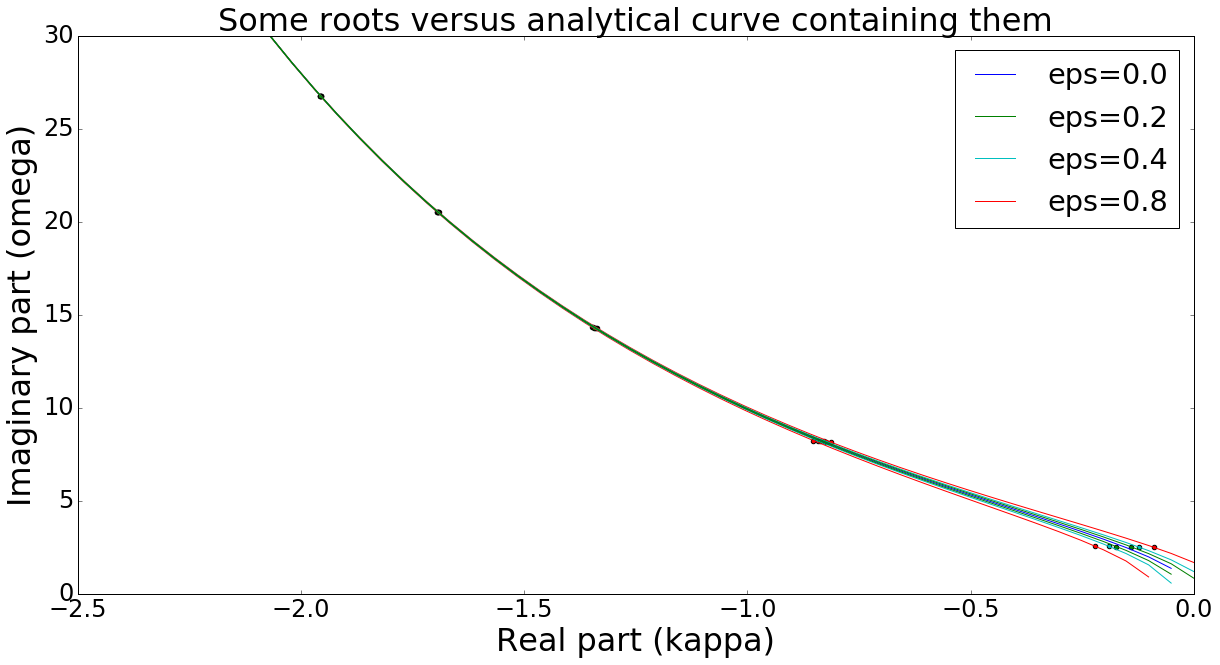

In [212]:
f = plt.figure(figsize=(20,10))

eps_eq_0, = plt.plot(xs_curve, ys_curve, c='b')

eps_eq_8,= plt.plot(xs_curve, ys_curve_disp1_minus, c='r')
plt.plot(xs_curve,  ys_curve_disp1_plus, c='r')

eps_eq_4,= plt.plot(xs_curve, ys_curve_disp2_minus, c='c')
plt.plot(xs_curve,  ys_curve_disp2_plus, c='c')

eps_eq_2, = plt.plot(xs_curve, ys_curve_disp3_minus, c='g')
plt.plot(xs_curve,  ys_curve_disp3_plus, c='g')


plt.scatter(DD_poles.real, DD_poles.imag, c = 'r')
plt.scatter(DD_poles2.real, DD_poles2.imag, c= 'c')
plt.scatter(DD_poles3.real, DD_poles3.imag, c= 'g')


# plt.title("Poles", fontsize=18)
plt.xlim(-2.5,0)
plt.ylim(0,30)
plt.xlabel("Real part (kappa)", fontsize=32)
plt.ylabel("Imaginary part (omega)", fontsize=32)
plt.title("Some roots versus analytical curve containing them", fontsize=32)

plt.legend([eps_eq_0, eps_eq_2, eps_eq_4, eps_eq_8], ["eps=0.0", "eps=0.2", "eps=0.4", "eps=0.8",])

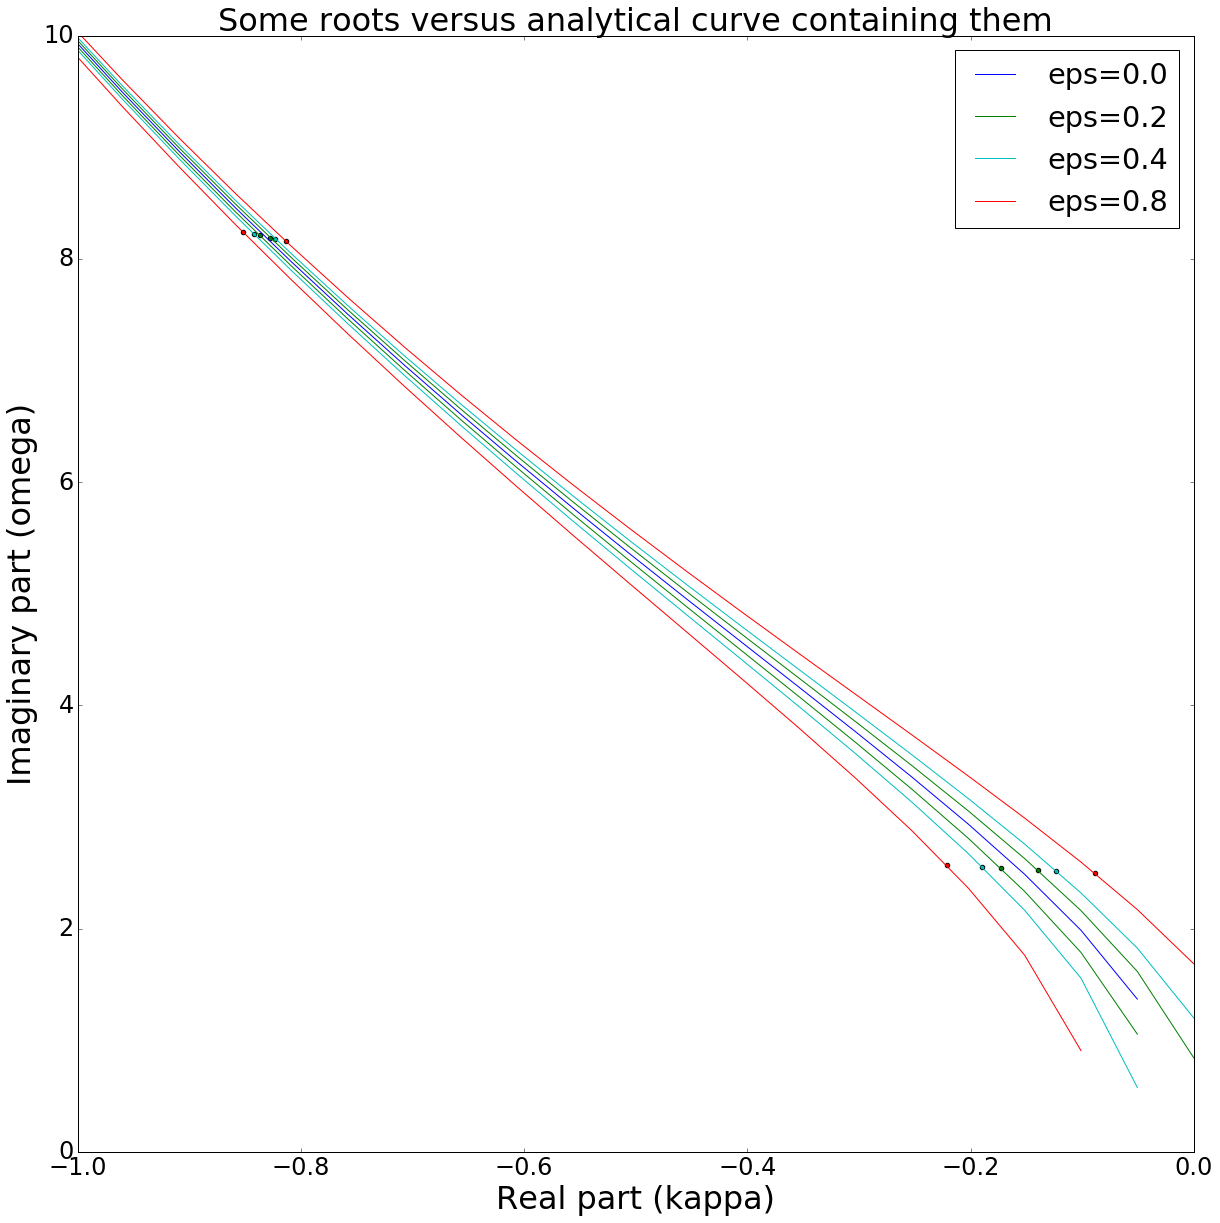

In [206]:
plt.figure(figsize=(20,20))

eps_eq_0, = plt.plot(xs_curve, ys_curve, c='b')

eps_eq_8,= plt.plot(xs_curve, ys_curve_disp1_minus, c='r')
plt.plot(xs_curve,  ys_curve_disp1_plus, c='r')

eps_eq_4,= plt.plot(xs_curve, ys_curve_disp2_minus, c='c')
plt.plot(xs_curve,  ys_curve_disp2_plus, c='c')

eps_eq_2, = plt.plot(xs_curve, ys_curve_disp3_minus, c='g')
plt.plot(xs_curve,  ys_curve_disp3_plus, c='g')


plt.scatter(DD_poles.real, DD_poles.imag, c = 'r')
plt.scatter(DD_poles2.real, DD_poles2.imag, c= 'c')
plt.scatter(DD_poles3.real, DD_poles3.imag, c= 'g')


# plt.title("Poles", fontsize=18)
plt.xlim(-1.,0)
plt.ylim(0,10)
plt.xlabel("Real part (kappa)", fontsize=32)
plt.ylabel("Imaginary part (omega)", fontsize=32)
plt.title("Some roots versus analytical curve containing them", fontsize=32)

plt.legend([eps_eq_0, eps_eq_2, eps_eq_4, eps_eq_8], ["eps=0.0", "eps=0.2", "eps=0.4", "eps=0.8",])

### Factorize the (degenerate) complex poles

In [101]:
# complex_poles

In [102]:
complex_poles[:10]

[(-0.13988556146609013+2.5247369007958911j),
 (-0.13988556146609013-2.5247369007958911j),
 (-0.17307512228223196+2.5428505388915736j),
 (-0.1730751222822319-2.5428505388915736j),
 (-0.82744725881412085-8.1912664060056279j),
 (-0.82744725881412073+8.1912664060056279j),
 (-0.83700708495594089-8.211027624996019j),
 (-0.83700708495594101+8.211027624996019j),
 (-1.3401284901974975-14.300710865616733j),
 (-1.3401284901974975+14.300710865616733j)]

In [154]:

which_poles = np.array([
                complex_poles[0], 
               complex_poles[2].conj(), 
], dtype = np.complex64)

In [155]:
conv = "consecutive"

In [156]:
which_poles

array([-0.13988556+2.52473688j, -0.17307512-2.54285049j], dtype=complex64)

In [158]:
which_vecs = factorize_complex_poles(which_poles, T_tilde, eps=1e-3, verbose=False, conv=conv)

R = [[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
R = [[ -2.29355477e+03+1232.79188057j   2.29780012e+03-1234.59059522j
    0.00000000e+00   +0.j           0.00000000e+00   +0.j        ]
 [ -2.29780012e+03+1234.59059522j   2.30205007e+03-1236.39177557j
    0.00000000e+00   +0.j           0.00000000e+00   +0.j        ]
 [  0.00000000e+00   +0.j           0.00000000e+00   +0.j
    1.00000000e+00   +0.j           0.00000000e+00   +0.j        ]
 [  0.00000000e+00   +0.j           0.00000000e+00   +0.j
    0.00000000e+00   +0.j           1.00000000e+00   +0.j        ]]


In [159]:
## Print the unperturbed vectors. They are degenerate when v.H*J*v = 0.
# which_vecs = factorize_complex_poles(which_poles, T_tilde, eps=2.5j, verbose=True, conv=conv)

T_c = lambda z: complex_prod_deg(z, which_poles, which_vecs, 4, conv=conv, eps =0, verbose=False)

In [163]:
print all([[check_J_unitary(T_c,i+1j*j, conv=conv, eps=1e-7, print_norm=False)
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_c,i+1j*j, conv=conv, eps=1e-7)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


### Generate and plot the factorized functions.

In [165]:
z0 = 0. ## Point at which we specify the new function should equal the original.
T_fact = lambda z: (
    T_tilde(z0) 
    *la.inv(T_c(z0))
    *T_c(z))

In [166]:
font = {'size' : 24}
matplotlib.rc('font', **font)

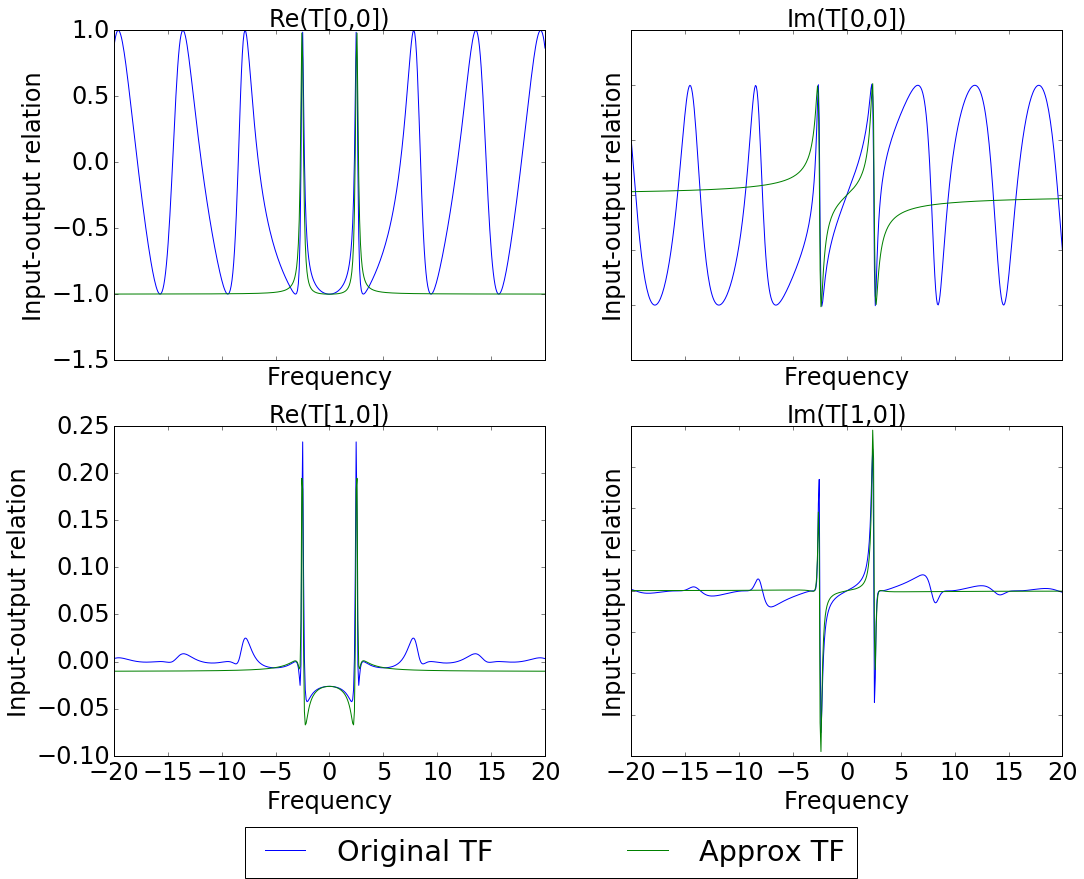

In [200]:

xr = numpy.linspace(-20,20,501)
xr_im = xr*1j
yr = numpy.array(map(T_tilde, xr_im))
zr = numpy.array(map(T_fact, xr_im))

f, axarr = plt.subplots(2, 2, figsize=(17,13))

l1, = axarr[0, 0].plot(xr, yr[:,0,0].real)
l2, = axarr[0, 0].plot(xr, zr[:,0,0].real)
axarr[0, 0].set_title('Re(T[0,0])',fontsize= 24)

axarr[0, 1].plot(xr, yr[:,0,0].imag)
axarr[0, 1].plot(xr, zr[:,0,0].imag)
axarr[0, 1].set_title('Im(T[0,0])' ,fontsize= 24)

axarr[1, 0].plot(xr, yr[:,1,0].real)
axarr[1, 0].plot(xr, zr[:,1,0].real)
axarr[1, 0].set_title('Re(T[1,0])',fontsize= 24 )

axarr[1, 1].plot(xr, yr[:,1,0].imag)
axarr[1, 1].plot(xr, zr[:,1,0].imag)
axarr[1, 1].set_title('Im(T[1,0])',fontsize= 24 )


f.legend([l1, l2],["Original TF", "Approx TF"],
           bbox_to_anchor=(0.2, 0.001, 0.5, .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)


for ax in axarr.flat:
    ax.set(xlabel='Frequency', ylabel='Input-output relation', )
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axarr.flat:
    ax.label_outer()
    


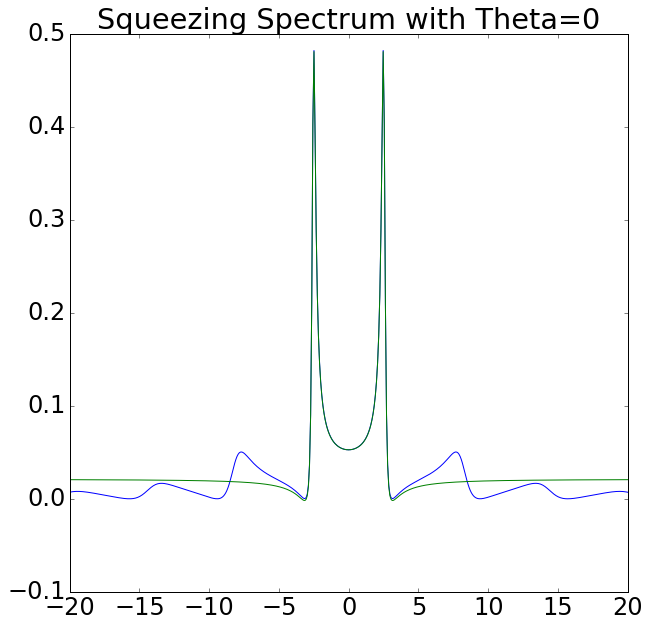

In [202]:
# Analysis of squeezing spectrum.

plt.figure(figsize=(10,10))

plt.title("Squeezing Spectrum with Theta=0")

PP = get_squeezed_spectrum(yr)
plt.plot(xr, PP)

PP = get_squeezed_spectrum(zr)
plt.plot(xr, PP)

## Note: We had to insert a value for $\epsilon$ in defining T_c because of the degeneracy (i.e. $v.H J  v  = 0$).  Unfortunately, there were two poles close to each other, and the resulting transfer function near the poles and the squeezing spectra were sensitive to the value of $\epsilon$. Still, we were able to replicate the overall qualitative behavior of the squeezing spectra.